## Deep Learning with Python (DLPy) and SAS Viya: Survival Analysis

The following example uses SAS DLPy to illustrate how we can easily apply a deep learning model for survival analysis. In this employee attrition example, we'd like to predict when an employee quit his job and understand the risk factors for employee turnover. This exmaple demonstrates that the deep survival model can achieve better prediction than the popular Cox proportional hazards model.

You can find the employee attrition Dataset at https://github.com/square/pysurvival/blob/master/pysurvival/datasets/employee_attrition.csv.

# Table of contents
1. [Survival Analysis and Its Application](#introduction)
2. [Employee Churn Data](#EDA)
3. [Deep Survival Model for Employee Churn Analysis](#build_deepsurv)
    1. [Build a Deep Learning Model with Survival Loss](#model_specification)
    2. [Train a Deep Learning Model](#model_training)    
4. [Evaluate Model Performance on Test Data Set](#evaluation)
5. [Summary](#summary)

## 1. Survival Analysis, Its Applications, and Censoring <a name="introduction"></a>

[Survival analysis](https://en.wikipedia.org/wiki/Survival_analysis) is widely used for analyzing life time data, where the target variable is the  duration/survival time until an event of interest occurs. One of the goals in survival analysis is to predict when an event of interest is likely to happen.

Survival analysis can be applied on many areas:

- Medical research: predict survival time after treatment
- Finance industry: predict when a borrower will likely to repay loan (credit risk)
- Churn analysis: understand why and when clients unsubscribe or stop their services
- Manufacturers: predict when an eletronic device will break

What is censoring and why does it matter?
- Censoring happens if an individual doesn't experience the event of interest during the study peroid. In this situation, the individual's survival time is censored and not fully observed. In the employee attrition example, if an employee still works in the company by the time of collecting the data, the employee's tenure time is censored.
- Standard regression models without accounting for censoring appropriately often lead to less accurate prediction and invalid inference. Instead, survival models can account for censoring and lead to better prediction and valid inference.

### Load packages and launch CAS

In [15]:
from swat import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.model_selection import train_test_split
import warnings
%matplotlib inline

import sys
#import pysurvival
sys.path.append('C:\\Users\\guilin\\PycharmProjects\\python-dlpy')

#import dlpy
import dlpy
from dlpy.layers import *
from dlpy.model import *
from dlpy.images import ImageTable
from dlpy.sequential import Sequential
from dlpy.lr_scheduler import *

In [2]:
#Connect to CAS server
s = CAS('dlgrd011.unx.sas.com', 11736)

## 2. The Employee Attrition Data <a name="EDA"></a>

In [3]:
#raw_dataset = pd.read_csv("../employee_attrition.csv")
df_employee = pd.read_csv("\\\\sashq\\root\\dept\\cas\\guilin\\cnn\employee_attrition.csv")
print("Size of the data set:", df_employee.shape)
df_employee.head()

Size of the data set: (14999, 10)


,satisfaction_level,last_evaluation,number_projects,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


###  Target variable and its distribution
- time_spend_company

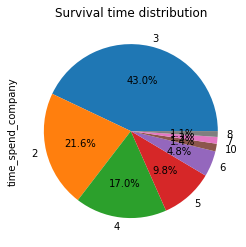

In [4]:
## define survival time and event status variable
time_column = 'time_spend_company' ## Time spent at the company
df_employee[time_column].value_counts().plot(kind='pie', autopct='%1.1f%%').set_title('Survival time distribution')
plt.show()

### Censoring indictor variable: left
#### 1: indicates that an employee left the company, so his/her duration time at the company is completely observed.
#### 0: indicates that an employee is still working in the company during the time of the study, so his/her duration time at the company is incompletly observed and censored.

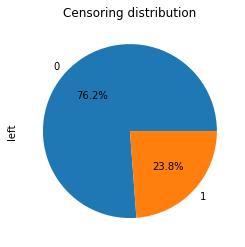

In [5]:
event_column = 'left'   ## censoring indicator whether the employee left the company   
df_employee[event_column].value_counts().plot(kind='pie', autopct='%1.1f%%').set_title('Censoring distribution')
plt.show()

Note: In this data set, 76.2% observations have censored target values. Standard regression methods, either by ignoring censoring information or dropping those censored observations can lead to biased and less accurate prediction.

###  Input features

#### satisfaction_level: employee satisfaction level by self evaluation

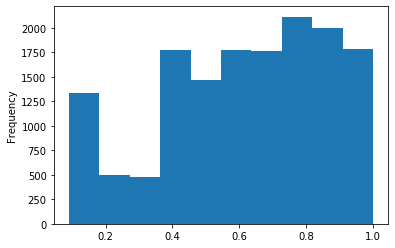

In [6]:
##satisfaction_level: employee satisfaction level by self evaluation
df_employee['satisfaction_level'].plot.hist(legend=None)
#plt.ylabel('')
plt.show()

###  Prepare data for survival analysis

#### Split data into training and test data
- We split the dataset to train (70% samples) and test (30% samples).

#### Prepare a target variable y for survival analysis
y is obtained by combining censoring information and original target values (time_spend_company)
-  y =   time_spend_company if left = 1 when an employee left the company
-  y = -1*time_spend_company if left = 0 when an employee didn't leave the company

In [7]:
N = df_employee.shape[0]
seed = 61386
index_train, index_test = train_test_split(range(N), test_size=0.3,random_state=seed)


dl_train = df_employee.loc[index_train].reset_index(drop=True)
dl_test  = df_employee.loc[index_test].reset_index(drop=True)

# NOTE: create y as target variable: negative for censored observations, and postive for uncensored observations
# y = time_spent if left=1 when an employee left the company
# y = -1* time_spent if left=0 when an employee is still in the company
dl_train['y'] = dl_train.apply(lambda row: (row[time_column] if row[event_column] else -row[time_column]), axis=1)
dl_test['y']  = dl_test.apply(lambda row: (row[time_column] if row[event_column] else -row[time_column]), axis=1)


# create id variable to identify each observation
# dl_train['id'] = np.arange(dl_train.shape[0])
dl_test['id'] = np.arange(dl_test.shape[0])

# upload the training and test data set into CAS
trainTbl = s.CASTable("train",replace=True)
testTbl = s.CASTable("test",replace=True)

CAS.upload_frame(s, dl_train,  casout=trainTbl)
CAS.upload_frame(s, dl_test,  casout=testTbl)

NOTE: Cloud Analytic Services made the uploaded file available as table TRAIN in caslib CASUSER(guilin).
NOTE: The table TRAIN has been created in caslib CASUSER(guilin) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table TEST in caslib CASUSER(guilin).
NOTE: The table TEST has been created in caslib CASUSER(guilin) from binary data uploaded to Cloud Analytic Services.


CASTable('TEST', caslib='CASUSER(guilin)')

In [8]:
# verify the data sets after split
splitRatio = trainTbl.shape[0]/(trainTbl.shape[0]+testTbl.shape[0])
train_string = "Size of training data: {}.  {:.1%} samples"
test_string = "Size of test data: {}.  {:.1%} samples"  
print(train_string.format(trainTbl.shape, splitRatio)) 
  
print(test_string.format(testTbl.shape, 1-splitRatio)) 

Size of training data: (10499, 11).  70.0% samples
Size of test data: (4500, 12).  30.0% samples


## 3. Deep Survival Model for Employee Attrition Analysis <a name="build_deepsurv"></a>

#### Specify inputs and target variables

In [9]:
print("Prepare input and target variables")
inputs = set(trainTbl.columninfo()["ColumnInfo"]["Column"]) ## set 
# a list of input variables are obtained by excluding target and censoring variables
inputs = list(inputs -{'y',time_column,event_column}) 

print("Number of input varibles:", len(inputs))
print("\nInput variables:\n", inputs)
nominals = ["department","salary"]
print("\nNominal inputs:", nominals)
# y is the target varaible instead of "time_spend_company"
print("\nTarget variable:","y") 

Prepare input and target variables
Number of input varibles: 8

Input variables:
 ['number_projects', 'department', 'salary', 'satisfaction_level', 'last_evaluation', 'promotion_last_5years', 'average_montly_hours', 'work_accident']

Nominal inputs: ['department', 'salary']

Target variable: y


### 3.1 Build a deep survival model<a name="model_specification"></a>
- The [deep survival model](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1) is a deep learning  model with the survival loss function

In [10]:
modelName='deepsurv_model';

inputVars = inputs
print("Input vars:",inputVars)
nInput= len(inputVars)
print("Number of inputs:",nInput)
nHidden = nInput + 5
print("Number of hidden units:",nHidden)
deepSurvModel = Sequential(s, model_table=modelName)
deepSurvModel.add(InputLayer(std='STD'))
deepSurvModel.add(Dense(n=nHidden, act='identity', include_bias=False))
deepSurvModel.add(BN(act='relu'))
deepSurvModel.add(Dense(n=nHidden, act='identity', include_bias=False))
deepSurvModel.add(BN(act='relu'))
# NOTE: the last dense layer should only have one neuron, and identity activation function is used. 
deepSurvModel.add(Dense(n=1, act='identity'))
# NOTE: specify the task layer (the last layer) as Survival layer to obtain the survival loss function
deepSurvModel.add(Survival())

Input vars: ['number_projects', 'department', 'salary', 'satisfaction_level', 'last_evaluation', 'promotion_last_5years', 'average_montly_hours', 'work_accident']
Number of inputs: 8
Number of hidden units: 13
NOTE: Input layer added.
NOTE: Fully-connected layer added.
NOTE: Batch normalization layer added.
NOTE: Fully-connected layer added.
NOTE: Batch normalization layer added.
NOTE: Fully-connected layer added.
NOTE: Survival layer added.
NOTE: Model compiled successfully.


In [11]:
# check available CAS tables
s.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Repeated,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,TRAIN,10499,11,0,utf-8,2020-02-27T15:09:31-05:00,2020-02-27T15:09:31-05:00,2020-02-27T15:09:34-05:00,UTF8,1.898453e+09,...,0,0,0,,,0,guilin,,2020-02-27T15:09:31-05:00,1.898453e+09
1,TEST,4500,12,0,utf-8,2020-02-27T15:09:31-05:00,2020-02-27T15:09:31-05:00,2020-02-27T15:09:34-05:00,UTF8,1.898453e+09,...,0,0,0,,,0,guilin,,2020-02-27T15:09:31-05:00,1.898453e+09
2,DEEPSURV_MODEL,53,5,0,utf-8,2020-02-27T15:09:39-05:00,2020-02-27T15:09:39-05:00,2020-02-27T15:09:39-05:00,UTF8,1.898453e+09,...,0,0,0,,,0,guilin,,,NaN


#### Plot deep survival model architecture

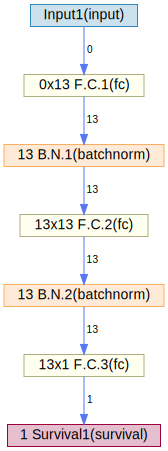

In [12]:
deepSurvModel.plot_network()

In [13]:
deepSurvModel.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,Input1,input,,,None,0,"(0, 0)",0
1,1,F.C.1,fc,"(0, 13)",,Identity,13,"(0, 0)",0
2,2,B.N.1,batchnorm,,,Relu,13,"(0, 2)",0
3,3,F.C.2,fc,"(13, 13)",,Identity,13,"(169, 0)",169
4,4,B.N.2,batchnorm,,,Relu,13,"(0, 2)",0
5,5,F.C.3,fc,"(13, 1)",,Identity,1,"(13, 0)",13
6,6,Survival1,survival,,,None,1,"(0, 0)",0
7,,,,,,,,Total number of parameters,Total FLOPS
8,Summary,,,,,,,186,182


### 3.2 Train deep survival model <a name="model_training"></a>

#### Specify  the momentum SGD optimizer and a learning rate scheduler

In [16]:
lr_scheduler = ReduceLROnPlateau(conn=s, cool_down_iters=3, gamma=0.8, learning_rate=0.001, patience=5)
solver = MomentumSolver(lr_scheduler = lr_scheduler,
                        momentum=0.9,
                        clip_grad_max = 100, clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, mini_batch_size=400, log_level=4, max_epochs=100, reg_l2=0.001)

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


####  Train deep survival model with momentum SGD

In [17]:
print(deepSurvModel.model_name)
s.droptable(deepSurvModel.model_weights.name)
deepsurvTrain_res = deepSurvModel.fit(
                      data=trainTbl,
                      data_specs=[
                      dict(layer='input1',type='numnom', data=inputVars,nominals=nominals),
                      dict(layer='survival1',type='numnom',data='y')],                      
                      n_threads= 2, 
                      record_seed=13309, 
                      optimizer=optimizer)

deepsurv_model
NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 482.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.01 (s).
NOTE:  The total number of threads on each worker is 2.
NOTE:  The total mini-batch size per thread on each worker is 400.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 800.
NOTE:  Target variable: y
NOTE:  Number of input variables:     8
NOTE:  Number of nominal input variables:      2
NOTE:  Number of numeric input variables:      6
NOTE:  Batch nUsed Learning Rate        Loss    C-Index    Correct  Incorrect       Tied     L2Norm   Time(s) (Training)
NOTE:      0   800    0.001            1.343     0.4764  3.573e+04  3.927e+04          0    0.02596     0.00
NOTE:      1   800    0.001            1.096     0.4864  3.025e+04  3.195e+04          0    0.02595     0.00
NOTE:      2   800

ERROR: The table deepsurv_model_weights could not be located in caslib CASUSER(guilin) of Cloud Analytic Services.
ERROR: The action stopped due to errors.


NOTE:      5   800    0.001           0.9938      0.719   4.32e+04  1.688e+04          0    0.02589     0.00
NOTE:      6   800    0.001            1.152     0.7106  4.819e+04  1.963e+04          0    0.02589     0.00
NOTE:      7   800    0.001            1.009      0.725  4.188e+04  1.589e+04          0    0.02589     0.00
NOTE:      8   800    0.001            1.054     0.7134  4.579e+04  1.839e+04          0    0.02589     0.00
NOTE:      9   800    0.001            1.136     0.7524  5.273e+04  1.735e+04          0    0.02589     0.00
NOTE:     10   800    0.001             1.06     0.7524  4.831e+04   1.59e+04          0    0.02589     0.00
NOTE:     11   800    0.001             1.02     0.7163  4.086e+04  1.618e+04          0    0.02589     0.00
NOTE:     12   800    0.001            1.028     0.7254  4.579e+04  1.733e+04          0    0.02589     0.00
NOTE:     13   800    0.001            1.077     0.6886  4.507e+04  2.038e+04          0    0.02589     0.00
NOTE:  Epoch Learni

NOTE:      5   800    0.001                1     0.8579  5.346e+04       8853          0    0.02589     0.00
NOTE:      6   800    0.001           0.9473       0.89  5.583e+04       6898          0    0.02589     0.00
NOTE:      7   800    0.001            1.104     0.8866  6.166e+04       7891          0    0.02589     0.00
NOTE:      8   800    0.001                1     0.8809  5.722e+04       7736          0    0.02589     0.00
NOTE:      9   800    0.001            1.016     0.8769  5.781e+04       8116          0    0.02589     0.00
NOTE:     10   800    0.001           0.9893     0.8749  5.444e+04       7786          0    0.02589     0.00
NOTE:     11   800    0.001            1.119     0.8582  5.999e+04       9911          0    0.02589     0.00
NOTE:     12   800    0.001            0.996     0.8653  5.232e+04       8143          0    0.02589     0.00
NOTE:     13   800    0.001           0.9812     0.8874  5.567e+04       7062          0    0.02589     0.00
NOTE:  Epoch Learni

NOTE:      4   800    0.001           0.9104     0.8887  5.429e+04       6800          0    0.02593     0.00
NOTE:      5   800    0.001            1.047     0.8849  5.893e+04       7666          0    0.02593     0.00
NOTE:      6   800    0.001            1.054     0.9275  6.489e+04       5075          0    0.02593     0.00
NOTE:      7   800    0.001            0.989     0.8798  5.536e+04       7562          0    0.02593     0.00
NOTE:      8   800    0.001           0.9951     0.9269  6.477e+04       5109          0    0.02593     0.00
NOTE:      9   800    0.001           0.9815     0.8884  5.443e+04       6839          0    0.02593     0.00
NOTE:     10   800    0.001           0.9344     0.9042  5.978e+04       6332          0    0.02593     0.00
NOTE:     11   800    0.001            1.002     0.8497  5.426e+04       9599          0    0.02593     0.00
NOTE:     12   800    0.001           0.9562      0.873   5.16e+04       7509          0    0.02593     0.00
NOTE:     13   800 

NOTE:      3   800    0.001           0.9644     0.9031  5.589e+04       5995          0    0.02599     0.00
NOTE:      4   800    0.001           0.9233     0.8936  5.626e+04       6699          0    0.02599     0.00
NOTE:      5   800    0.001           0.8905      0.909  5.592e+04       5595          0    0.02599     0.00
NOTE:      6   800    0.001            0.985     0.9049  5.793e+04       6091          0    0.02599     0.00
NOTE:      7   800    0.001            1.067     0.9398  6.521e+04       4176          0    0.02599     0.00
NOTE:      8   800    0.001           0.9942     0.8977      6e+04       6836          0    0.02599     0.00
NOTE:      9   800    0.001            0.913     0.9189  5.558e+04       4907          0    0.02599     0.00
NOTE:     10   800    0.001            0.947     0.9136  5.241e+04       4954          0    0.02599     0.00
NOTE:     11   800    0.001           0.9568     0.9271  6.124e+04       4814          0    0.02599     0.00
NOTE:     12   800 

NOTE:      0   800    0.001             0.93     0.8766  5.883e+04       8279          0    0.02603     0.00
NOTE:      1   800    0.001           0.9376     0.9268  6.005e+04       4741          0    0.02603     0.00
NOTE:      2   800    0.001            1.005     0.9058  6.159e+04       6406          0    0.02603     0.00
NOTE:      3   800    0.001            1.032     0.9016  6.209e+04       6777          0    0.02603     0.00
NOTE:      4   800    0.001           0.9458     0.9097  5.835e+04       5790          0    0.02603     0.00
NOTE:      5   800    0.001           0.8423      0.912   5.15e+04       4968          0    0.02603     0.00
NOTE:      6   800    0.001           0.9233     0.9178  5.776e+04       5172          0    0.02603     0.00
NOTE:      7   800    0.001           0.9875     0.9199  6.358e+04       5533          0    0.02603     0.00
NOTE:      8   800    0.001           0.9158     0.9263  6.224e+04       4955          0    0.02604     0.00
NOTE:      9   800 

NOTE:      6   800    0.001             1.05     0.8995  6.595e+04       7371          0    0.02606     0.00
NOTE:      7   800    0.001           0.8587     0.9192  5.855e+04       5150          0    0.02606     0.00
NOTE:      8   800    0.001           0.8915      0.905  5.865e+04       6158          0    0.02606     0.00
NOTE:      9   800    0.001            1.044     0.8866  6.442e+04       8237          0    0.02606     0.00
NOTE:     10   800    0.001           0.8793     0.9056  5.695e+04       5936          0    0.02606     0.00
NOTE:     11   800    0.001           0.9527     0.9291  6.491e+04       4952          0    0.02606     0.00
NOTE:     12   800    0.001           0.8636     0.9415  5.922e+04       3679          0    0.02606     0.00
NOTE:     13   800    0.001           0.9257     0.9393  6.138e+04       3967          0    0.02606     0.00
NOTE:  Epoch Learning Rate        Loss    C-Index    Correct  Incorrect       Tied   Time(s)
NOTE:  33        0.001          0.9

NOTE:      9   800   0.0008           0.9199     0.8941  5.702e+04       6753          0    0.02608     0.00
NOTE:     10   800   0.0008            1.007     0.9016  6.236e+04       6807          0    0.02608     0.00
NOTE:     11   800   0.0008           0.9875     0.9191  6.576e+04       5791          0    0.02608     0.00
NOTE:     12   800   0.0008           0.9761     0.9065  6.021e+04       6214          0    0.02608     0.00
NOTE:     13   800   0.0008           0.9154     0.9192   6.02e+04       5293          0    0.02608     0.00
NOTE:  Epoch Learning Rate        Loss    C-Index    Correct  Incorrect       Tied   Time(s)
NOTE:  40       0.0008          0.9279     0.9103  8.219e+05  8.099e+04          0     0.03
NOTE:  Batch nUsed Learning Rate        Loss    C-Index    Correct  Incorrect       Tied     L2Norm   Time(s) (Training)
NOTE:      0   800   0.0008            0.861     0.8929  5.481e+04       6573          0    0.02608     0.00
NOTE:      1   800   0.0008           0.

NOTE:     13   800   0.0008           0.8384     0.9262  5.767e+04       4595          0    0.02609     0.00
NOTE:  Epoch Learning Rate        Loss    C-Index    Correct  Incorrect       Tied   Time(s)
NOTE:  47       0.0008          0.8707     0.9227  7.994e+05  6.696e+04          0     0.03
NOTE:  Batch nUsed Learning Rate        Loss    C-Index    Correct  Incorrect       Tied     L2Norm   Time(s) (Training)
NOTE:      0   800   0.0008           0.9704     0.9226  6.309e+04       5289          0    0.02609     0.00
NOTE:      1   800   0.0008           0.8796     0.9209  5.747e+04       4935          0    0.02609     0.00
NOTE:      2   800   0.0008           0.9409     0.8833  5.552e+04       7335          0    0.02609     0.00
NOTE:      3   800   0.0008           0.8426     0.9093  5.626e+04       5612          0    0.02609     0.00
NOTE:      4   800   0.0008           0.9704     0.9411   6.28e+04       3929          0    0.02609     0.00
NOTE:      5   800   0.0008            1

NOTE:      0   800  0.00064           0.9591     0.8951  5.694e+04       6670          0    0.02608     0.00
NOTE:      1   800  0.00064            0.886     0.9278  5.967e+04       4646          0    0.02608     0.00
NOTE:      2   800  0.00064           0.9157     0.9125   5.95e+04       5705          0    0.02608     0.00
NOTE:      3   800  0.00064           0.8896     0.9228   6.04e+04       5055          0    0.02608     0.00
NOTE:      4   800  0.00064           0.8548     0.8934  5.083e+04       6066          0    0.02608     0.00
NOTE:      5   800  0.00064           0.9668      0.894  5.646e+04       6697          0    0.02608     0.00
NOTE:      6   800  0.00064           0.8608     0.9086  5.645e+04       5677          0    0.02608     0.00
NOTE:      7   800  0.00064           0.9243     0.9311  6.316e+04       4676          0    0.02608     0.00
NOTE:      8   800  0.00064           0.8374     0.9282  5.426e+04       4195          0    0.02608     0.00
NOTE:      9   800 

NOTE:      1   800  0.00064            0.935     0.9131   5.99e+04       5697          0    0.02607     0.00
NOTE:      2   800  0.00064           0.9378     0.8857  5.913e+04       7632          0    0.02607     0.00
NOTE:      3   800  0.00064           0.8982     0.9118  5.848e+04       5655          0    0.02607     0.00
NOTE:      4   800  0.00064           0.8924     0.9399   5.98e+04       3824          0    0.02607     0.00
NOTE:      5   800  0.00064           0.9044     0.9373   6.36e+04       4252          0    0.02607     0.00
NOTE:      6   800  0.00064           0.9025     0.9035  5.569e+04       5949          0    0.02607     0.00
NOTE:      7   800  0.00064           0.9701      0.899  6.115e+04       6869          0    0.02607     0.00
NOTE:      8   800  0.00064           0.9086     0.9208  6.189e+04       5323          0    0.02607     0.00
NOTE:      9   800  0.00064           0.9519     0.9243  6.137e+04       5024          0    0.02607     0.00
NOTE:     10   800 

NOTE:      4   800 0.000512           0.8457     0.9334  5.678e+04       4051          0    0.02606     0.00
NOTE:      5   800 0.000512            1.014     0.9305  6.712e+04       5014          0    0.02606     0.00
NOTE:      6   800 0.000512           0.9235     0.9165  6.124e+04       5581          0    0.02606     0.00
NOTE:      7   800 0.000512           0.8325       0.91  5.839e+04       5774          0    0.02606     0.00
NOTE:      8   800 0.000512           0.8063     0.9333  5.826e+04       4161          0    0.02606     0.00
NOTE:      9   800 0.000512            1.023     0.9031  6.214e+04       6667          0    0.02606     0.00
NOTE:     10   800 0.000512            0.796     0.9094  5.602e+04       5583          0    0.02606     0.00
NOTE:     11   800 0.000512           0.7614     0.9521  5.323e+04       2679          0    0.02606     0.00
NOTE:     12   800 0.000512           0.9506     0.9316  6.239e+04       4581          0    0.02606     0.00
NOTE:     13   800 

NOTE:      7   800  0.00041           0.8644     0.9132  5.554e+04       5278          0    0.02605     0.00
NOTE:      8   800  0.00041           0.8638     0.9246   5.89e+04       4804          0    0.02605     0.00
NOTE:      9   800  0.00041           0.9603     0.9141  6.341e+04       5955          0    0.02605     0.00
NOTE:     10   800  0.00041           0.8732     0.9337  5.492e+04       3899          0    0.02605     0.00
NOTE:     11   800  0.00041           0.8869     0.9321  6.125e+04       4458          0    0.02605     0.00
NOTE:     12   800  0.00041           0.9779     0.9296  6.546e+04       4958          0    0.02605     0.00
NOTE:     13   800  0.00041           0.9196     0.9089    5.6e+04       5611          0    0.02605     0.00
NOTE:  Epoch Learning Rate        Loss    C-Index    Correct  Incorrect       Tied   Time(s)
NOTE:  76       0.0004           0.897     0.9219  8.245e+05  6.985e+04          0     0.03
NOTE:  Batch nUsed Learning Rate        Loss    C-In

NOTE:     11   800 0.000328           0.8682     0.9202  5.493e+04       4761          0    0.02604     0.00
NOTE:     12   800 0.000328            1.019     0.9067  6.883e+04       7087          0    0.02604     0.00
NOTE:     13   800 0.000328           0.8551     0.9059  5.239e+04       5445          0    0.02604     0.00
NOTE:  Epoch Learning Rate        Loss    C-Index    Correct  Incorrect       Tied   Time(s)
NOTE:  83       0.0003          0.8848     0.9186  8.184e+05  7.249e+04          0     0.03
NOTE:  Batch nUsed Learning Rate        Loss    C-Index    Correct  Incorrect       Tied     L2Norm   Time(s) (Training)
NOTE:      0   800 0.000328           0.8844     0.9047  5.445e+04       5734          0    0.02604     0.00
NOTE:      1   800 0.000328           0.9232     0.9183  6.173e+04       5491          0    0.02604     0.00
NOTE:      2   800 0.000328           0.8373     0.9517  6.083e+04       3085          0    0.02604     0.00
NOTE:      3   800 0.000328           0.

NOTE:  Epoch Learning Rate        Loss    C-Index    Correct  Incorrect       Tied   Time(s)
NOTE:  90       0.0003          0.8513     0.9261  7.967e+05  6.357e+04          0     0.03
NOTE:  Batch nUsed Learning Rate        Loss    C-Index    Correct  Incorrect       Tied     L2Norm   Time(s) (Training)
NOTE:      0   800 0.000262           0.8691     0.9254  5.602e+04       4518          0    0.02603     0.00
NOTE:      1   800 0.000262           0.8856     0.9396  6.573e+04       4228          0    0.02603     0.00
NOTE:      2   800 0.000262           0.8176     0.9421  5.843e+04       3593          0    0.02603     0.00
NOTE:      3   800 0.000262           0.8588     0.9441  5.929e+04       3509          0    0.02603     0.00
NOTE:      4   800 0.000262            0.786     0.9385  5.488e+04       3597          0    0.02603     0.00
NOTE:      5   800 0.000262           0.8539     0.9495  5.833e+04       3101          0    0.02603     0.00
NOTE:      6   800 0.000262           0.

NOTE:      2   800 0.000262           0.8504     0.9086  5.748e+04       5779          0    0.02603     0.00
NOTE:      3   800 0.000262           0.9184     0.9301   5.94e+04       4467          0    0.02603     0.00
NOTE:      4   800 0.000262           0.8713     0.9436  6.168e+04       3687          0    0.02603     0.00
NOTE:      5   800 0.000262           0.9736     0.9437  6.559e+04       3916          0    0.02603     0.00
NOTE:      6   800 0.000262            1.091     0.9227  6.628e+04       5555          0    0.02603     0.00
NOTE:      7   800 0.000262           0.8913     0.9244  5.855e+04       4790          0    0.02603     0.00
NOTE:      8   800 0.000262           0.8802     0.9211  5.891e+04       5049          0    0.02602     0.00
NOTE:      9   800 0.000262            1.011     0.8718  5.404e+04       7946          0    0.02602     0.00
NOTE:     10   800 0.000262           0.7658     0.9413  5.368e+04       3345          0    0.02602     0.00
NOTE:     11   800 

#### Visualize training loss history to check model convergence

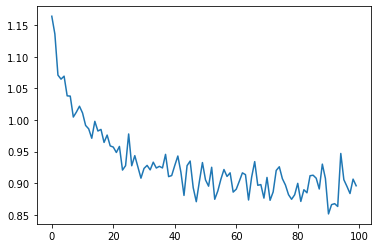

In [18]:
plt.plot(deepsurvTrain_res["OptIterHistory"][["Loss"]])

### 3.3 Build [Cox proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model)
- 

In [19]:
modelName='cox_model';
coxModel = Sequential(s, model_table=modelName)
coxModel.add(InputLayer(std='STD'))
coxModel.add(Dense(n=1, act='identity', include_bias=False))
coxModel.add(Survival())

NOTE: Input layer added.
NOTE: Fully-connected layer added.
NOTE: Survival layer added.
NOTE: Model compiled successfully.


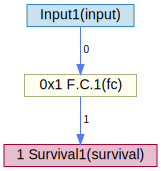

In [21]:
coxModel.plot_network()

In [22]:
coxModel.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,Input1,input,,,None,0,"(0, 0)",0
1,1,F.C.1,fc,"(0, 1)",,Identity,1,"(0, 0)",0
2,2,Survival1,survival,,,None,1,"(0, 0)",0
3,,,,,,,,Total number of parameters,Total FLOPS
4,Summary,,,,,,,0,0


### 3.4Train Cox model

In [23]:
optimizer = Optimizer(algorithm=solver, mini_batch_size=200, log_level=4, max_epochs=200, reg_l2=0.001)
# start to train
print(coxModel.model_name)
s.droptable(coxModel.model_weights.name)
coxTrain_res = coxModel.fit(
                      data=trainTbl,
                      data_specs=[
                      dict(layer='input1', type='numnom', data=(inputVars), nominals=nominals),
                      dict(layer='survival1', type='numnom', data='y')],
                      n_threads= 2, 
                      record_seed=13309, 
                      optimizer=optimizer)

cox_model
NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 19.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.01 (s).
NOTE:  The total number of threads on each worker is 2.
NOTE:  The total mini-batch size per thread on each worker is 200.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 400.
NOTE:  Target variable: y
NOTE:  Number of input variables:     8
NOTE:  Number of nominal input variables:      2
NOTE:  Number of numeric input variables:      6
NOTE:  Batch nUsed Learning Rate        Loss    C-Index    Correct  Incorrect       Tied     L2Norm   Time(s) (Training)
NOTE:      0   400    0.001            1.077     0.8081  1.473e+04       3497          0   0.001145     0.00
NOTE:      1   400    0.001            1.148     0.7558  1.378e+04       4454          0   0.001145     0.00
NOTE:      2   400    0.

ERROR: The table cox_model_weights could not be located in caslib CASUSER(guilin) of Cloud Analytic Services.
ERROR: The action stopped due to errors.


NOTE:      3   400    0.001            1.054     0.8315  1.585e+04       3213          0   0.001026     0.00
NOTE:      4   400    0.001           0.9805     0.8681  1.504e+04       2284          0   0.001026     0.00
NOTE:      5   400    0.001           0.8555     0.8305  1.202e+04       2454          0   0.001026     0.00
NOTE:      6   400    0.001           0.8305     0.8355  1.306e+04       2571          0   0.001026     0.00
NOTE:      7   400    0.001           0.9513     0.8182  1.335e+04       2965          0   0.001027     0.00
NOTE:      8   400    0.001            1.044     0.8469  1.472e+04       2661          0   0.001027     0.00
NOTE:      9   400    0.001            1.007     0.8275  1.478e+04       3080          0   0.001027     0.00
NOTE:     10   400    0.001           0.8482     0.7781  1.177e+04       3355          0   0.001027     0.00
NOTE:     11   400    0.001           0.9796     0.8544  1.475e+04       2513          0   0.001027     0.00
NOTE:     12   400 

NOTE:     10   400   0.0008           0.8796     0.8167  1.231e+04       2763          0   0.001085     0.00
NOTE:     11   400   0.0008           0.7661      0.822  1.085e+04       2349          0   0.001085     0.00
NOTE:     12   400   0.0008           0.8858     0.8387  1.467e+04       2821          0   0.001085     0.00
NOTE:     13   400   0.0008           0.8179     0.8762  1.328e+04       1876          0   0.001085     0.00
NOTE:     14   400   0.0008           0.8714     0.8561  1.284e+04       2158          0   0.001086     0.00
NOTE:     15   400   0.0008           0.7989     0.8523  1.259e+04       2182          0   0.001086     0.00
NOTE:     16   400   0.0008           0.8419     0.8436  1.199e+04       2223          0   0.001086     0.00
NOTE:     17   400   0.0008           0.8602     0.8561  1.372e+04       2307          0   0.001086     0.00
NOTE:     18   400   0.0008           0.9182     0.8369  1.398e+04       2726          0   0.001087     0.00
NOTE:     19   400 

NOTE:     18   400  0.00064           0.9358     0.8296  1.364e+04       2801          0   0.001154     0.00
NOTE:     19   400  0.00064           0.8067     0.8483    1.3e+04       2325          0   0.001154     0.00
NOTE:     20   400  0.00064           0.9265     0.8727  1.537e+04       2243          0   0.001154     0.00
NOTE:     21   400  0.00064           0.8115     0.8664  1.357e+04       2093          0   0.001154     0.00
NOTE:     22   400  0.00064            0.795     0.8685  1.272e+04       1925          0   0.001154     0.00
NOTE:     23   400  0.00064           0.9989     0.8361  1.494e+04       2929          0   0.001155     0.00
NOTE:     24   400  0.00064           0.7856     0.8786  1.235e+04       1706          0   0.001155     0.00
NOTE:     25   400  0.00064            0.746     0.8682  1.236e+04       1876          0   0.001155     0.00
NOTE:     26   400  0.00064           0.9225     0.8493  1.366e+04       2424          0   0.001155     0.00
NOTE:  Epoch Learni

NOTE:     16   400 0.000512            0.827     0.8762  1.241e+04       1754          0   0.001201     0.00
NOTE:     17   400 0.000512           0.9356     0.8863  1.462e+04       1876          0   0.001201     0.00
NOTE:     18   400 0.000512            0.832     0.8163  1.186e+04       2669          0   0.001201     0.00
NOTE:     19   400 0.000512            0.891     0.8732  1.611e+04       2340          0   0.001201     0.00
NOTE:     20   400 0.000512            0.896     0.8304  1.165e+04       2380          0   0.001201     0.00
NOTE:     21   400 0.000512           0.7572     0.8541  1.195e+04       2040          0   0.001201     0.00
NOTE:     22   400 0.000512           0.8209     0.8799  1.313e+04       1793          0   0.001201     0.00
NOTE:     23   400 0.000512           0.7831      0.856  1.237e+04       2082          0   0.001201     0.00
NOTE:     24   400 0.000512           0.8988     0.8429   1.48e+04       2759          0   0.001201     0.00
NOTE:     25   400 

NOTE:      5   400  0.00041            1.023     0.8663  1.616e+04       2494          0   0.001237     0.00
NOTE:      6   400  0.00041            1.044     0.8505  1.562e+04       2745          0   0.001237     0.00
NOTE:      7   400  0.00041           0.9454     0.8773   1.46e+04       2041          0   0.001237     0.00
NOTE:      8   400  0.00041           0.8531     0.8304  1.379e+04       2815          0   0.001237     0.00
NOTE:      9   400  0.00041           0.9442     0.8328  1.339e+04       2688          0   0.001237     0.00
NOTE:     10   400  0.00041           0.9929     0.8729  1.696e+04       2469          0   0.001237     0.00
NOTE:     11   400  0.00041           0.9032     0.8718  1.439e+04       2117          0   0.001237     0.00
NOTE:     12   400  0.00041           0.8493     0.8373  1.199e+04       2330          0   0.001237     0.00
NOTE:     13   400  0.00041           0.9101     0.8708  1.377e+04       2043          0   0.001237     0.00
NOTE:     14   400 

NOTE:     14   400 0.000328           0.8072     0.8352  1.133e+04       2236          0    0.00126     0.00
NOTE:     15   400 0.000328           0.8519     0.8498  1.175e+04       2077          0    0.00126     0.00
NOTE:     16   400 0.000328            1.034     0.8678  1.556e+04       2369          0   0.001261     0.00
NOTE:     17   400 0.000328           0.7398     0.8861  1.244e+04       1598          0   0.001261     0.00
NOTE:     18   400 0.000328           0.8998     0.8708  1.439e+04       2134          0   0.001261     0.00
NOTE:     19   400 0.000328           0.8818     0.8766  1.429e+04       2012          0   0.001261     0.00
NOTE:     20   400 0.000328           0.8503      0.897  1.438e+04       1651          0   0.001261     0.00
NOTE:     21   400 0.000328           0.8884     0.8992  1.512e+04       1695          0   0.001261     0.00
NOTE:     22   400 0.000328           0.8423     0.8444  1.223e+04       2253          0   0.001261     0.00
NOTE:     23   400 

NOTE:  Batch nUsed Learning Rate        Loss    C-Index    Correct  Incorrect       Tied     L2Norm   Time(s) (Training)
NOTE:      0   400 0.000262           0.9439     0.8778  1.429e+04       1989          0   0.001274     0.00
NOTE:      1   400 0.000262           0.8931     0.8442  1.317e+04       2431          0   0.001274     0.00
NOTE:      2   400 0.000262           0.8036     0.8417  1.188e+04       2234          0   0.001274     0.00
NOTE:      3   400 0.000262           0.9846     0.8409  1.518e+04       2872          0   0.001274     0.00
NOTE:      4   400 0.000262           0.8926     0.8468   1.36e+04       2461          0   0.001274     0.00
NOTE:      5   400 0.000262           0.7913     0.8573  1.204e+04       2003          0   0.001274     0.00
NOTE:      6   400 0.000262           0.7867     0.8482  1.141e+04       2041          0   0.001274     0.00
NOTE:      7   400 0.000262           0.7844     0.8992  1.413e+04       1584          0   0.001274     0.00
NOTE:  

NOTE:      5   400  0.00021           0.9577     0.8464  1.476e+04       2677          0    0.00128     0.00
NOTE:      6   400  0.00021           0.8436     0.8631   1.32e+04       2093          0    0.00128     0.00
NOTE:      7   400  0.00021           0.8291     0.8833  1.402e+04       1853          0    0.00128     0.00
NOTE:      8   400  0.00021           0.8875      0.867  1.358e+04       2084          0    0.00128     0.00
NOTE:      9   400  0.00021            1.027     0.8826  1.575e+04       2095          0    0.00128     0.00
NOTE:     10   400  0.00021           0.8129     0.8719  1.318e+04       1937          0    0.00128     0.00
NOTE:     11   400  0.00021            1.042     0.8582  1.582e+04       2614          0    0.00128     0.00
NOTE:     12   400  0.00021           0.8709     0.8349  1.332e+04       2634          0    0.00128     0.00
NOTE:     13   400  0.00021            0.896     0.8374    1.3e+04       2524          0    0.00128     0.00
NOTE:     14   400 

NOTE:  Epoch Learning Rate        Loss    C-Index    Correct  Incorrect       Tied   Time(s)
NOTE:  101      0.0002          0.8883      0.852   3.73e+05  6.482e+04          0     0.01
NOTE:  Batch nUsed Learning Rate        Loss    C-Index    Correct  Incorrect       Tied     L2Norm   Time(s) (Training)
NOTE:      0   400 0.000168            0.808     0.8669  1.231e+04       1890          0    0.00129     0.00
NOTE:      1   400 0.000168           0.9188     0.8373  1.359e+04       2640          0    0.00129     0.00
NOTE:      2   400 0.000168           0.8771     0.8504  1.252e+04       2203          0    0.00129     0.00
NOTE:      3   400 0.000168           0.9111     0.8764  1.591e+04       2244          0    0.00129     0.00
NOTE:      4   400 0.000168           0.8418      0.893  1.449e+04       1736          0    0.00129     0.00
NOTE:      5   400 0.000168           0.9675     0.8285  1.428e+04       2954          0    0.00129     0.00
NOTE:      6   400 0.000168           0.

NOTE:     17   400 0.000134           0.8709     0.8617  1.329e+04       2134          0   0.001296     0.00
NOTE:     18   400 0.000134           0.8486     0.9055  1.539e+04       1605          0   0.001296     0.00
NOTE:     19   400 0.000134           0.8217     0.8932   1.44e+04       1722          0   0.001296     0.00
NOTE:     20   400 0.000134           0.8586     0.8277  1.277e+04       2659          0   0.001296     0.00
NOTE:     21   400 0.000134           0.8263     0.9002  1.457e+04       1616          0   0.001296     0.00
NOTE:     22   400 0.000134           0.8873     0.8805  1.533e+04       2080          0   0.001296     0.00
NOTE:     23   400 0.000134           0.8278     0.8289  1.313e+04       2710          0   0.001296     0.00
NOTE:     24   400 0.000134           0.7652     0.8872  1.261e+04       1603          0   0.001296     0.00
NOTE:     25   400 0.000134           0.7992     0.8548  1.239e+04       2104          0   0.001296     0.00
NOTE:     26   400 

NOTE:      5   400 0.000107           0.8357     0.9143  1.544e+04       1447          0   0.001301     0.00
NOTE:      6   400 0.000107           0.9436     0.8373  1.378e+04       2677          0   0.001301     0.00
NOTE:      7   400 0.000107            1.029     0.8572  1.605e+04       2675          0   0.001301     0.00
NOTE:      8   400 0.000107             1.09     0.8575  1.637e+04       2719          0   0.001301     0.00
NOTE:      9   400 0.000107           0.8087     0.8615  1.372e+04       2206          0   0.001301     0.00
NOTE:     10   400 0.000107           0.7837     0.8567  1.194e+04       1997          0   0.001301     0.00
NOTE:     11   400 0.000107           0.9232     0.8592  1.444e+04       2366          0   0.001301     0.00
NOTE:     12   400 0.000107           0.8686     0.8585  1.343e+04       2214          0   0.001301     0.00
NOTE:     13   400 0.000107           0.9545     0.8951   1.63e+04       1911          0   0.001301     0.00
NOTE:     14   400 

NOTE:     22   400 0.000086           0.8148     0.8698  1.293e+04       1935          0   0.001306     0.00
NOTE:     23   400 0.000086           0.9926      0.869   1.55e+04       2337          0   0.001306     0.00
NOTE:     24   400 0.000086           0.8854     0.8703  1.483e+04       2210          0   0.001306     0.00
NOTE:     25   400 0.000086            0.908     0.8448  1.459e+04       2679          0   0.001306     0.00
NOTE:     26   400 0.000086           0.7395     0.8592  1.133e+04       1857          0   0.001306     0.00
NOTE:  Epoch Learning Rate        Loss    C-Index    Correct  Incorrect       Tied   Time(s)
NOTE:  136      0.0001          0.8853     0.8526  3.717e+05  6.427e+04          0     0.01
NOTE:  Batch nUsed Learning Rate        Loss    C-Index    Correct  Incorrect       Tied     L2Norm   Time(s) (Training)
NOTE:      0   400 0.000069            1.009     0.8575  1.501e+04       2493          0   0.001306     0.00
NOTE:      1   400 0.000069           0.

NOTE:     25   400 0.000055           0.7934     0.8605  1.315e+04       2131          0    0.00131     0.00
NOTE:     26   400 0.000055           0.7665      0.891   1.38e+04       1689          0    0.00131     0.00
NOTE:  Epoch Learning Rate        Loss    C-Index    Correct  Incorrect       Tied   Time(s)
NOTE:  148       55E-6          0.8691     0.8631   3.68e+05  5.835e+04          0     0.01
NOTE:  Batch nUsed Learning Rate        Loss    C-Index    Correct  Incorrect       Tied     L2Norm   Time(s) (Training)
NOTE:      0   400 0.000055           0.8498     0.8445  1.193e+04       2197          0    0.00131     0.00
NOTE:      1   400 0.000055            0.938     0.8438  1.467e+04       2714          0    0.00131     0.00
NOTE:      2   400 0.000055           0.7245     0.8721  1.262e+04       1852          0    0.00131     0.00
NOTE:      3   400 0.000055           0.8431     0.8543  1.257e+04       2143          0    0.00131     0.00
NOTE:      4   400 0.000055           0.

NOTE:  Batch nUsed Learning Rate        Loss    C-Index    Correct  Incorrect       Tied     L2Norm   Time(s) (Training)
NOTE:      0   400 0.000044           0.9958     0.8563  1.484e+04       2490          0   0.001313     0.00
NOTE:      1   400 0.000044           0.9374     0.8763  1.533e+04       2164          0   0.001313     0.00
NOTE:      2   400 0.000044           0.8941      0.877  1.473e+04       2065          0   0.001313     0.00
NOTE:      3   400 0.000044           0.9028     0.8498   1.53e+04       2704          0   0.001313     0.00
NOTE:      4   400 0.000044            0.814      0.855  1.346e+04       2283          0   0.001313     0.00
NOTE:      5   400 0.000044           0.9548     0.8794  1.444e+04       1980          0   0.001313     0.00
NOTE:      6   400 0.000044            0.832     0.8086  1.263e+04       2988          0   0.001313     0.00
NOTE:      7   400 0.000044            1.071     0.8421  1.687e+04       3162          0   0.001313     0.00
NOTE:  

NOTE:     12   400 0.000028           0.9952     0.8507  1.468e+04       2577          0   0.001315     0.00
NOTE:     13   400 0.000028           0.9119     0.8754  1.615e+04       2299          0   0.001315     0.00
NOTE:     14   400 0.000028           0.8418     0.8356  1.327e+04       2612          0   0.001315     0.00
NOTE:     15   400 0.000028           0.9571      0.867  1.433e+04       2197          0   0.001315     0.00
NOTE:     16   400 0.000028           0.9229     0.8532  1.514e+04       2604          0   0.001315     0.00
NOTE:     17   400 0.000028           0.8365     0.8874  1.491e+04       1892          0   0.001315     0.00
NOTE:     18   400 0.000028           0.8174     0.8543  1.362e+04       2324          0   0.001315     0.00
NOTE:     19   400 0.000028            1.044     0.8627  1.545e+04       2458          0   0.001315     0.00
NOTE:     20   400 0.000028            0.761     0.8848  1.301e+04       1694          0   0.001315     0.00
NOTE:     21   400 

NOTE:     15   400 0.000018           0.9096     0.8682  1.493e+04       2266          0   0.001316     0.00
NOTE:     16   400 0.000018            0.919     0.8783  1.385e+04       1919          0   0.001316     0.00
NOTE:     17   400 0.000018           0.9269     0.8141   1.25e+04       2854          0   0.001316     0.00
NOTE:     18   400 0.000018           0.9429     0.8617  1.465e+04       2351          0   0.001316     0.00
NOTE:     19   400 0.000018           0.9094     0.8687  1.501e+04       2269          0   0.001316     0.00
NOTE:     20   400 0.000018           0.9821     0.8696    1.5e+04       2250          0   0.001316     0.00
NOTE:     21   400 0.000018           0.8764     0.8618  1.318e+04       2113          0   0.001316     0.00
NOTE:     22   400 0.000018           0.8679     0.8407   1.32e+04       2500          0   0.001316     0.00
NOTE:     23   400 0.000018           0.8617      0.853  1.193e+04       2057          0   0.001316     0.00
NOTE:     24   400 

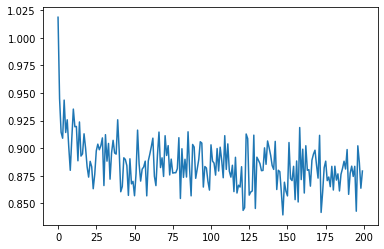

In [25]:
plt.plot(coxTrain_res["OptIterHistory"][["Loss"]])
plt.show()

## 4. Evaluate  Model Performance <a name="evaluation"></a> 

### 4.1 Overall model predictive performance in terms of C-Index on test data

- C-index (Concordance index) is a commonly used metric to evaluate and compare survival model's discriminative power.
- It is calculated as the fraction of pairs of observations whose observed and predicted outcomes agree among all possible pairs. That is, the longer the observed survival time is, the higher the predicted survival probability is.
- The higher the C-index is, the better the model is.

#### C-Index for Cox survival model

In [26]:
# specify log_level=4 to compute C-Index for Cox model
coxModel.predict(testTbl,buffer_size=10000,log_level=4)

NOTE: Due to data distribution, miniBatchSize has been limited to 66.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.01 (s).
NOTE:  Batch nUsed Learning Rate        Loss    C-Index    Correct  Incorrect       Tied   Time(s) (Validation)
NOTE:      0  4500        0           0.6322     0.8544  1.765e+06  3.007e+05          0     0.00


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          4500
 1  Number of Observations Used          4500
 2                   Loss Error       0.63222

[CumHazard]

    Time    CumHaz
 0   2.0  0.001916
 1   3.0  0.076830
 2   4.0  0.175121
 3   5.0  0.381753
 4   6.0  0.492437

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(guilin)  Valid_Res_t1FoGP  4500       13   
 
                                             casTable  
 0  CASTable('Valid_Res_t1FoGP', caslib='CASUSER(g...  

+ Elapsed: 0.0387s, user: 0.0744s, sys: 0.0387s, mem: 156mb

#### C-Index for deep survival model

In [27]:
# specify log_level=4 to compute C-Index for deep survival model
deepSurvModel.predict(testTbl,buffer_size=10000,log_level=4)

NOTE: Due to data distribution, miniBatchSize has been limited to 66.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.01 (s).
NOTE:  Batch nUsed Learning Rate        Loss    C-Index    Correct  Incorrect       Tied   Time(s) (Validation)
NOTE:      0  4500        0           0.4849     0.9283  1.917e+06   1.48e+05          0     0.00


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          4500
 1  Number of Observations Used          4500
 2                   Loss Error      0.484949

[CumHazard]

    Time    CumHaz
 0   2.0  0.000541
 1   3.0  0.019206
 2   4.0  0.073149
 3   5.0  0.210213
 4   6.0  0.308992

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(guilin)  Valid_Res_OJxyPm  4500       13   
 
                                             casTable  
 0  CASTable('Valid_Res_OJxyPm', caslib='CASUSER(g...  

+ Elapsed: 0.0363s, user: 0.0579s, sys: 0.0575s, mem: 156mb

### <center> Comparison of model predictive performance on test data in terms of C-Index</center>
| Model | C-Index |
| --- | --- | 
| Cox Model | 0.86 |
| Deep Survival Model | 0.93 |

### 4.2 Predict the employees who are likely quit and when they will quit

In [28]:
# step 1: Obtain cumulative hazard estimates
surv_model = deepSurvModel
score_trainTbl = surv_model.predict(trainTbl)
print(score_trainTbl)
# step 2: predict hazard rate
surv_model.predict(testTbl)
predicted_hazard  = surv_model.valid_res_tbl
predicted_hazard.head()

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read         10499
 1  Number of Observations Used         10499
 2                   Loss Error       0.15264

[CumHazard]

    Time    CumHaz
 0   2.0  0.000605
 1   3.0  0.019045
 2   4.0  0.078120
 3   5.0  0.216710
 4   6.0  0.317541

[OutputCasTables]

             casLib              Name   Rows  Columns  \
 0  CASUSER(guilin)  Valid_Res_OJxyPm  10499       12   
 
                                             casTable  
 0  CASTable('Valid_Res_OJxyPm', caslib='CASUSER(g...  

+ Elapsed: 0.0434s, user: 0.106s, sys: 0.059s, mem: 156mb


,satisfaction_level,last_evaluation,number_projects,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary,y,id,_DL_Pred_
0,0.15,0.74,6.0,144.0,7.0,0.0,0.0,1.0,management,high,-7.0,0.0,0.131263
1,0.09,0.83,6.0,282.0,4.0,0.0,1.0,0.0,technical,medium,4.0,1.0,7.894433
2,0.45,0.46,2.0,130.0,3.0,0.0,1.0,0.0,technical,low,3.0,2.0,57.076889
3,0.46,0.55,2.0,145.0,3.0,0.0,1.0,0.0,technical,low,3.0,3.0,34.535267
4,0.45,0.87,2.0,268.0,4.0,1.0,0.0,0.0,IT,low,-4.0,4.0,0.733552


### Plot predicted hazard scores on test data set
- Employees can be classified into two groups in terms of predicted risk scores: 
- High risk group with score>10 and low risk group with score<10. 
- Employees in the high risk group are more likely quit than those in the low risk group

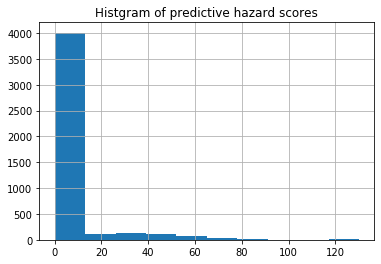

In [29]:
predicted_hazard["_DL_Pred_"].hist(bins=10)
plt.title("Histgram of predictive hazard scores")
plt.show()

#### Predict survival function for given inputs
- Step 1. We score with the training data set to obtain the baseline cumulative hazards, and get the hazard prediction for these individuals
-  Step 2. By combining the baseline cumulative hazard function and the hazard prediction, we can obtain survival function for these individuals

In [34]:
def dl_survival_function(df_baselineCumHazard, df_hazard, id=None):
    # id: column for observation identity
    # import pandas as pd
    if not isinstance(df_baselineCumHazard, SASDataFrame) and not isinstance(df_hazard, pd.DataFrame):
        #print("Error:input types must be data frame")
        raise TypeError("inputs must be data frame!")

    survival = pd.DataFrame()
    survival["Time"] = df_baselineCumHazard["Time"]
    s = np.outer(-1*df_baselineCumHazard["CumHaz"],df_hazard["_DL_Pred_"])
    s = np.exp(s)
    # create column names with prefex id
    if isinstance(id, str):   
        idColumns = [id+'='+str(v) for v in df_hazard[id]]
        s = pd.DataFrame(s,columns=idColumns)
    else:
        s = pd.DataFrame(s)             
    survival = pd.concat([survival, s], axis=1)
    return survival          

#### For illustrative purpose, we compute the predicted survival function of two  employees: one is chosen from the high risk group and the other is chosen from the low risk group.

In [35]:
# step 1:
df_hazard = predicted_hazard.to_frame()
df_baselineCum_hazard= pd.DataFrame(score_trainTbl["CumHazard"])

# step 2:
dl_survival = dl_survival_function(df_baselineCum_hazard, df_hazard, id=None)
# id for risk groups based on deep learning model
# 
risk_cutoff = 10
riskGroup = {"low risk":(df_hazard[df_hazard._DL_Pred_<risk_cutoff].id).reset_index(drop=True),
             "high risk": df_hazard[df_hazard._DL_Pred_>risk_cutoff].id.reset_index(drop=True)}
low = riskGroup["low risk"]
df_low = (df_hazard.loc[df_hazard["id"].isin(low)])
# employees who left the company
df_low = df_low[df_low.left==1]

high = riskGroup["high risk"]
df_high = (df_hazard.loc[df_hazard["id"].isin(high)])
df_high = df_high[df_high.left==1] ## employees who left the company
id = [df_low.id.iloc[1],df_high.id.iloc[1]] ##
print("An employee's id from the low risk group in the test data set: {}".format(int(id[0])))
print("An employee's id from the high risk group in the test data set: {}".format(int(id[1])))

An employee's id from the low risk group in the test data set: 6
An employee's id from the high risk group in the test data set: 3


#### Plot and compare predicted survival functions between individuals from different risk groups

In [36]:
def plot_survival(survival, hazard_df, modelName=None, id=None):
    
    colors=['red','blue']
    if id is None:
        id=[0,1]  
        
    eventTimes = list(df_hazard[hazard_df.id==id[0]].time_spend_company) +  list(hazard_df[hazard_df.id==id[1]].time_spend_company)## series

    print("Time spent in company for two employees:{} and {}".format(int(eventTimes[0]),int(eventTimes[1])))
    predHazard = list(hazard_df[hazard_df.id==id[0]]._DL_Pred_) +  list(hazard_df[hazard_df.id==id[1]]._DL_Pred_)## series
    
    print("Predicted hazards for two employees:",predHazard)    
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.plot(survival.Time, survival[id[0]],color=colors[0],label='low risk')
    plt.plot(survival.Time, survival[id[1]],color=colors[1],label='high risk')
    # Actual time
    plt.axvline(x=eventTimes[0],  color=colors[0], ls ='--')
    plt.axvline(x=eventTimes[1],  color=colors[1], ls ='--')
    i=0
    ax.annotate('T={:.1f}'.format(eventTimes[0]), xy=(eventTimes[0], 0.5*(1.+0.2*i)),
            xytext=(eventTimes[0], 0.5*(1.+0.2*i)), fontsize=12)
    i=1
    ax.annotate('T={:.1f}'.format(eventTimes[1]), xy=(eventTimes[1], 0.5*(1.+0.2*i)),
            xytext=(eventTimes[1], 0.5*(1.+0.2*i)), fontsize=12)

    title = "Comparing survival functions from {} groups".format("low risk and high risk")
    if isinstance(modelName, str):
        title = modelName + ": " + title
    plt.legend(fontsize=12)
    plt.title(title, fontsize=15)
    plt.ylabel("Survival probability")
    plt.xlabel("Time spent in company")    
    plt.ylim(0, 1.05)
    plt.show()
    return

Time spent in company for two employees:5 and 3
Predicted hazards for two employees: [1.276875615119934, 34.5352668762207]


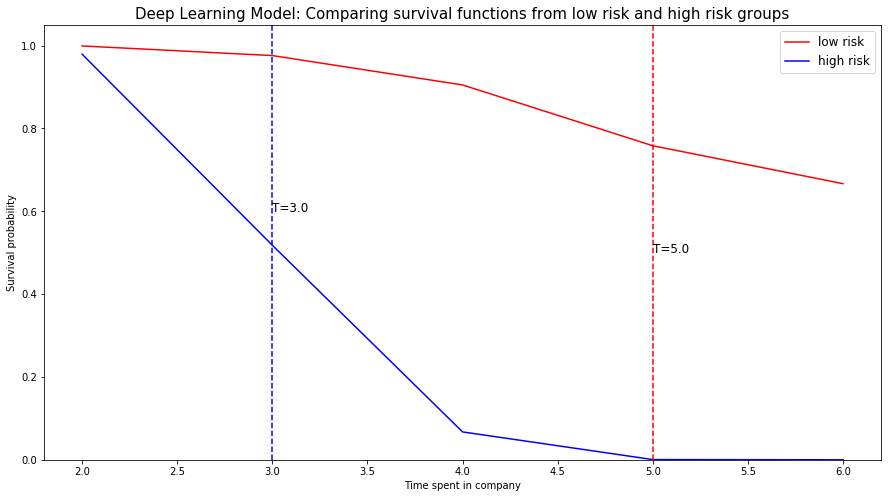

In [37]:
plot_survival(dl_survival, df_hazard, modelName="Deep Learning Model",id=id)

- As we expect, the predicted survival curve for the employee with low risk is above the one with hight risk, since the employee from the high risk group has higher hazard rate than the employee from teh low risk group.
- From the survial function of the employee from the high risk group, we can tell that he spent at this company more than 3 years with the probability less than .5. From the test data set, we can tell that the employee did leave the company at the 3rd year.

#### 4.4 Understand and identify risk factors that contribute to employee's attrition
- Find how an employee's satisfaction_level impacts his/her time spent at the company

In [38]:
# prepare input data to predict survival probability curves
employee1 =testTbl[testTbl.id==df_high.id.iloc[1]]
input_df = employee1.to_frame()

input_df["department"]=["technical  "] ## For varchar, RawLength need match
input_df["salary"]=["low   "] ## For varchar, RawLength need match
input_df = pd.concat([input_df]*3, ignore_index=True)
input_df["satisfaction_level"] = [0.3,0.5,0.7]
input_df["id"] = [i  for i in  range(3)]
inputTbl = s.CASTable("input",replace=True)
CAS.upload_frame(s, input_df,  casout=inputTbl)

NOTE: Cloud Analytic Services made the uploaded file available as table INPUT in caslib CASUSER(guilin).
NOTE: The table INPUT has been created in caslib CASUSER(guilin) from binary data uploaded to Cloud Analytic Services.


CASTable('INPUT', caslib='CASUSER(guilin)')

In [40]:
employee1.head()

,satisfaction_level,last_evaluation,number_projects,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary,y,id
0,0.46,0.55,2.0,145.0,3.0,0.0,1.0,0.0,technical,low,3.0,3.0


In [98]:
# uncomment code below to verify the input data
# inputTbl.head()

In [41]:
# step 1: Obtain cumulative hazard estimates
surv_model = deepSurvModel
#surv_model = CoxModel
score_trainTbl = surv_model.predict(trainTbl)

print(score_trainTbl)
### step 2: predict hazard rate
surv_model.predict(inputTbl)
predicted_hazard  = surv_model.valid_res_tbl
print("\n Predicted hazard scores:")
predicted_hazard.head()

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read         10499
 1  Number of Observations Used         10499
 2                   Loss Error       0.15264

[CumHazard]

    Time    CumHaz
 0   2.0  0.000605
 1   3.0  0.019045
 2   4.0  0.078120
 3   5.0  0.216710
 4   6.0  0.317541

[OutputCasTables]

             casLib              Name   Rows  Columns  \
 0  CASUSER(guilin)  Valid_Res_OJxyPm  10499       12   
 
                                             casTable  
 0  CASTable('Valid_Res_OJxyPm', caslib='CASUSER(g...  

+ Elapsed: 0.046s, user: 0.131s, sys: 0.0485s, mem: 156mb
NOTE: Due to data distribution, miniBatchSize has been limited to 1.

 Predicted hazard scores:


,satisfaction_level,last_evaluation,number_projects,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary,y,id,_DL_Pred_
0,0.3,0.55,2.0,145.0,3.0,0.0,1.0,0.0,technical,low,3.0,0.0,58.874691
1,0.5,0.55,2.0,145.0,3.0,0.0,1.0,0.0,technical,low,3.0,1.0,30.223619
2,0.7,0.55,2.0,145.0,3.0,0.0,1.0,0.0,technical,low,3.0,2.0,10.510350


In [42]:
hazard_df = predicted_hazard.to_frame()
baselineCumHazard_df= pd.DataFrame(score_trainTbl["CumHazard"])
dl_survival = dl_survival_function(baselineCumHazard_df,hazard_df, id="id")

#### Plot predicted survival function on various satisfaction levels

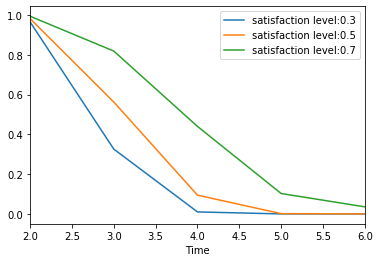

In [43]:
ax = dl_survival[list(dl_survival.columns)].plot(x="Time", y=list(dl_survival.columns)[1])
dl_survival[list(dl_survival.columns)].plot(x="Time", y=dl_survival.columns[2],  ax=ax) ## suppress warning from plot
dl_survival[list(dl_survival.columns)].plot(x="Time", y=dl_survival.columns[3],  ax=ax)
plt.gca().legend(('satisfaction level:0.3','satisfaction level:0.5','satisfaction level:0.7'))
plt.show()

### The survivial functions  for various satisfaction levels in the plot show that the employee's satisfaction level has positive relationship with the employee' tenure time in this company.

### 5. Summary <a name="summary"></a> 

Survival analysis provides a valid and powerful way to analyze survival data with censoring. In the employee attrition analysis, the deep survival model can automatically learn a complex and nonlinear function to predict an emloyee's turnover risk, and perform better than the popular Cox proportional hazards model.

### Reference

- https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1 DeepSurv: personalized treatment recommender system using a Cox proportional hazards deep neural network
- https://square.github.io/pysurvival/index.html PySurvival package for survival anlayis
- https://github.com/square/pysurvival/blob/master/pysurvival/datasets/employee_attrition.csv Employee Attrition Data Set from PySurvival
- https://square.github.io/pysurvival/tutorials/employee_retention.html Knowing when your employees will quit
- http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit DeepHit: A Deep Learning Approach to Survival Analysis with Competing Risks
- https://www.jstor.org/stable/pdf/2985181.pdf Cox Proportional Hazards Model
- https://support.sas.com/documentation/onlinedoc/stat/141/phreg.pdf The PHREG Procedure from SAS
- https://rpubs.com/dmorgan26/telecomschurn  Telecoms Churn - Predicting Customer Turnover

In [17]:
!jupyter nbconvert --to script DLPy_DeepSurv_Employee_Churn_Analysis.ipynb

[NbConvertApp] Converting notebook DLPy_DeepSurv_Employee_Churn_Analysis.ipynb to script
[NbConvertApp] Writing 20148 bytes to DLPy_DeepSurv_Employee_Churn_Analysis.py


In [ ]:
# close the session
s.endsession()